# 3D CNN

In [1]:
# wether to use tpu for training or not
USE_TPU = False
TRAIN_MODEL = False
RANDOM_SEED = 4200

In [2]:
from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from google.colab import auth


GCLOUD_PROJECT_ID = 'fiit-dp'
# ./logs and ./checkpints directories must exist in the bucket
GCLOUD_STORAGE_BUCKET = 'fiit-dp-training'


if USE_TPU:
  auth.authenticate_user()

  !gcloud config set project '$GCLOUD_PROJECT_ID'

In [4]:
if USE_TPU:
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
  !apt -qq update
  !apt -qq install gcsfuse

In [5]:
if USE_TPU:
  !mkdir 'gcs_bucket'
  !gcsfuse '$GCLOUD_STORAGE_BUCKET' 'gcs_bucket'

In [6]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [7]:
# Install SimpleITK
!pip install SimpleITK

# Install tf-nightly
# !pip install tf-nightly

In [8]:
import tensorflow as tf

tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
Num GPUs Available:  0


In [9]:
import os

saliencies_and_segmentations_v2_path = "/content/gdrive/My Drive/saliencies_and_segmentations_v2"

def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join(saliencies_and_segmentations_v2_path, sub_path)

## MRISequence


In [10]:
import os
import math

import sklearn
import numpy as np
import SimpleITK as sitk

from keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from skimage.transform import resize


def process_image(path, input_shape, resize_img, normalization):
    x = sitk.GetArrayFromImage(sitk.ReadImage(path))
    if resize_img == True:
      x = resize(x, input_shape[:3])
    if normalization is not None:
      x = normalize(x, normalization)
    return np.array(x).reshape(input_shape)

def invert_img(x):
    # [x, y, z, 1]
    return x[:, :, ::-1, :]

def normalize(x, normalization):
    desc = normalization['desc']
    if normalization['type'] != 'standardization':
      return (x - desc['min']) / (desc['max'] - desc['min'])
    return (x - desc['mean']) / desc['std']

def apply_augmentation(x, augmentations, name, force=False):
    if name == 'random_swap_hemispheres':
      p = augmentations['random_swap_hemispheres']
      if force or np.random.uniform(0) < p:
        return invert_img(x), True
    return x, False

def apply_augmentations(x, augmentations):
    if augmentations is None:
      return x

    for augmentation in augmentations.keys():
      x, applied = apply_augmentation(x, augmentations, augmentation)
      if applied:
        return x

    return x

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class MRISequence(Sequence):
    def __init__(self, path, batch_size, input_shape, class_names=['AD', 'CN'], 
                 augmentations=None, augmentations_inplace=True, images=True, one_hot=True, class_weight=None,
                 normalization=None, resize_img=True):
      if one_hot == False:
        self.encoder = LabelEncoder()
        self.encoder.fit(np.array(class_names))
      else:
        self.encoder = OneHotEncoder(sparse=False)
        self.encoder.fit(np.array(class_names).reshape(-1, 1))

      self.class_weight = class_weight
      self.one_hot = one_hot
      self.input_shape = input_shape
      self.resize_img = resize_img
      self.class_names = class_names
      self.images = images
      self.augmentations = augmentations
      self.augmentations_inplace = augmentations_inplace
      self.normalization = normalization

      self.batch_size = batch_size
      self.images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
        
    def __len__(self):
        return math.ceil(len(self.images_dirs) / self.batch_size)
        # Uncomment for debugging (when you need a smaller subset of data and faster training time)
        # return math.ceil(18 / self.batch_size)

    def __getitem__(self, idx):
        images_dirs = self.images_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        if not len(images_dirs):
          batch_y = np.array([]).reshape(-1)
          if self.one_hot:
            batch_y = np.array([]).reshape(-1, len(self.class_names))

          return np.array([]).reshape(-1, *input_shape), batch_y

        batch_y = self.__encode(np.array([self.__readfile(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs]))

        # if we disabled loading images, don't do it
        if not self.images:
          batch_x = np.array([None for image_dir in images_dirs])
        else:
          batch_x = np.array([process_image(os.path.join(image_dir, 'data.nii'), self.input_shape, self.resize_img, self.normalization) for image_dir in images_dirs])
          
          if self.augmentations:
            if self.augmentations_inplace:
              batch_x = np.array([apply_augmentations(x, self.augmentations) for x in batch_x])
            else:
              new_batch_x = np.array([]).reshape(-1, *input_shape)
              new_batch_y = np.array([]).reshape(-1, len(self.class_names))
              
              for augmentation in self.augmentations.keys():
                aug_batch_x = np.array([x for x, _ in [apply_augmentation(x, augmentations, augmentation, force=True) for x in batch_x]])
                new_batch_x = np.concatenate((new_batch_x, aug_batch_x), axis=0)
                new_batch_y = np.concatenate((new_batch_y, np.copy(batch_y)), axis=0)

              batch_x = np.concatenate((batch_x, new_batch_x), axis=0)
              batch_y = np.concatenate((batch_y, new_batch_y), axis=0)
        
        if self.class_weight is None:
          return batch_x, batch_y

        batch_w = np.array([self.class_weight[y] for y in self.__decode(batch_y)])
        return batch_x, batch_y, batch_w

    def __encode(self, labels):
      if self.one_hot == True:
        labels = labels.reshape(-1, 1)
      return self.encoder.transform(labels)

    def __decode(self, labels):
      if self.one_hot == True:
          return np.argmax(labels, axis=1)
      return labels

    def __readfile(self, file_path):
        fo = open(file_path, "r")
        c = fo.readline()
        fo.close()
        return c

## seq_to_np()

Converts sequence to numpy array. If the sequence exists in storage, load it.


In [11]:
def seq_to_np(seq, path, name):
  path_x = os.path.join(path, f'{name}_x.npy')
  path_y = os.path.join(path, f'{name}_y.npy')

  if os.path.exists(path_x):
    print(f'loading {path_x}, {path_y}...')

    with open(path_x, 'rb') as f:
      train_x = np.load(f, allow_pickle=True)
    with open(path_y, 'rb') as f:
      train_y = np.load(f, allow_pickle=True)
    
    return train_x.reshape((-1, *seq.input_shape)), train_y.reshape(-1, len(seq.class_names))

  print(f'generating {path_x}, {path_y}...')

  train_x = []
  train_y = []

  for batch_x, batch_y, *r in train_seq:
    if batch_x is not None and batch_y is not None:
      for x, y in zip(batch_x, batch_y):
          train_x.append(x)
          train_y.append(y)

  with open(path_x, 'wb') as f:
    np.save(f, np.array(train_x))
  with open(path_y, 'wb') as f:
    np.save(f, np.array(train_y))

  return np.array(train_x).reshape((-1, *seq.input_shape)), np.array(train_y).reshape(-1, len(seq.class_names))

## train_test_split()

In [12]:
import os
import time
import shutil
import numpy as np

from tqdm import tqdm


def train_test_split(src, dst, **kwargs):
  split = kwargs.get('split', (0.8, 0.1, 0.1))
  dirname = kwargs.get('dirname', str(int(time.time())))

  if len(split) != 3:
    raise "split mus be length of three!"

  if sum(split) != 1:
    raise "sum of split must be 1!"

  dst_dir = os.path.join(dst, f'{dirname}')
  train_dir = os.path.join(dst_dir, 'train')
  test_dir = os.path.join(dst_dir, 'test')
  val_dir = os.path.join(dst_dir, 'val')
  
  if os.path.exists(dst_dir):
    print("not copying files since the destination directory already exists")

    return train_dir, test_dir, val_dir

  os.mkdir(dst_dir)
  print(f"copying to {dst_dir}...\n")

  # list of directories to copy
  src_dirs = os.listdir(src)
  print('shuffling an array...')
  np.random.shuffle(src_dirs)

  print('copying files...')
  src_dirs_count = len(src_dirs)
  for idx, dir in tqdm(enumerate(src_dirs), total=src_dirs_count):
    dst_dir = train_dir

    if idx > split[0] * src_dirs_count:
      dst_dir = test_dir
    if idx > (split[0] + split[1]) * src_dirs_count:
      dst_dir = val_dir

    shutil.copytree(os.path.join(src, dir), os.path.join(dst_dir, dir))

  return train_dir, test_dir, val_dir


# train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/')

In [13]:
import tensorflow as tf

from keras.layers import Lambda


@tf.function
def random_invert_img(x, p):
  if tf.random.uniform([]) < p:
    # [x, y, z, 1]
    return x[:, :, ::-1, :]
  return x

def RandomSwapBrainHemisphere(factor=0.5):
  return Lambda(lambda x: random_invert_img(x, factor))

## MRITensorBoardCallback

In [14]:
import io
import os
import itertools
import matplotlib.pyplot as plt

from keras.callbacks import Callback


def to_rgb_image(img, pred_label=None, true_label=None, z_index=None, add_batch_dim=True):
  figure = plt.figure(figsize=(4, 4))
  plt.imshow(img.reshape(img.shape[:-1])[z_index], cmap='gray')
  if true_label is not None and pred_label is not None:
    plt.title(f'true = {true_label}, pred = {pred_label}')
  return plot_to_image(figure, add_batch_dim)


def plot_to_image(figure, add_batch_dim=True):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside 
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  if add_batch_dim:
    # Add the batch dimension
    image = tf.expand_dims(image, 0)  
  return image


def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix', fontsize=36)
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = 'white' if cm[i, j] > threshold else 'black'
    plt.text(j, i, labels[i, j], horizontalalignment='center', color=color, fontsize=18)

  plt.tight_layout()
  plt.ylabel('True label', fontsize=18)
  plt.xlabel('Predicted label', fontsize=18)
  return figure


class MRITensorBoardCallback(Callback):
    def __init__(self, seq, model, z_index=56, max_outputs=18, freq=3, log_dir=None, debug=True):
        """
        seq is the sequence from which is the data taken
        model to fit
        z_index is the index in the 3D image which is visualised
        log_dir is the where is output logged
        max_outputs number of images to output
        freq determines how frequently (each freq epoch) to outpu to tensorboard
        """
        super(MRITensorBoardCallback, self).__init__()
        self.model = model
        self.seq = seq
        self.log_dir = log_dir
        self.z_index = z_index
        self.max_outputs = max_outputs
        self.freq = freq
        self.debug = debug

    def __get_z_index(self, img):
      return max(min(img.shape[1], self.z_index), 0)

    def __debug(self, msg):
      if self.debug:
        print(msg)

    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.freq != 0:
        self.__debug('skipping evaluation of predictions to tensorboard')
        return

      self.__debug(f'evaluation of predictions to tensorboard for epoch #{epoch} (no of batches is {len(self.seq)})...')

      images = []
      class_names = self.seq.class_names
      y_pred = np.array([]).reshape(-1, len(class_names))
      y_true = np.array([]).reshape(-1, len(class_names))

      # Get predictions in batches for seq
      for index, batch in enumerate(self.seq):
        x, y, _ = batch
        self.__debug(f'batch #{index}')
        # Get predictions
        pred = self.model.predict(x)

        # Merge with other predictions
        y_true = np.concatenate([y_true, y])
        y_pred = np.concatenate([y_pred, pred])

        # Encode labels
        true_labels = self.seq.encoder.inverse_transform(y)
        pred_labels = self.seq.encoder.inverse_transform(pred)

        # Do not create more images than we output
        if len(images) >= self.max_outputs:
          continue;

        rgb_images = [to_rgb_image(image, pred_label=pred, true_label=true, z_index=self.z_index, add_batch_dim=False) for image, pred, true in zip(x, pred_labels.reshape(-1), true_labels.reshape(-1))]
        for rgb_image in rgb_images:
          images.append(rgb_image)

      # Create a confussion matrix
      cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
                                                                
      # Log the confusion matrix as an image summary.
      figure = plot_confusion_matrix(cm, class_names=class_names)
      cm_image = plot_to_image(figure)

      file_writer_cm = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/confussion-matrix'))
      file_writer_images = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/images'))

      with file_writer_images.as_default():
        # Don't forget to reshape.
        images = images[0:self.max_outputs]
        tf.summary.image("Validation Images", images, max_outputs=self.max_outputs, step=epoch)

      # Log the confusion matrix as an image summary.
      with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

## Evaluation

### plot_training_history()

In [15]:
import os
import tempfile
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_training_history(history):
  metrics = list(filter(lambda metric: 'val_' not in metric, history.history.keys()))
  ncols = 3
  nrows = math.ceil(len(metrics) / ncols)
  plt.figure(figsize=(nrows * 6, nrows * 6 * 1.25))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(ncols, nrows, n + 1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.xlim([0, len(history.epoch)])
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8, 1])
    else:
      plt.ylim([0,1])

    plt.legend()

### custom_classification_report

In [16]:
from sklearn.metrics import classification_report, mean_squared_error, mean_squared_log_error, explained_variance_score, f1_score, accuracy_score, recall_score, make_scorer


def custom_classification_report(class_names, y_true, y_pred, **kwargs):
    clf_report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Custom print because of incorrect formatting of original function
    for key in clf_report:
        if isinstance(clf_report[key], dict):
            print(f'\033[1m{key}\033[0m')

            for metric in clf_report[key]:
                print(f'{metric}: {clf_report[key][metric]}')
        else:
            print(f'{key}: {clf_report[key]}')

        print('\n')
        
    print(f'\033[1mF1\033[0m')
    for average in ['micro', 'macro']:
        print(f'{average}: {f1_score(y_true, y_pred, average=average)}')

    print('\n')
    # https://en.wikipedia.org/wiki/Precision_and_recall
    # https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    sensitivity_score = make_scorer(recall_score)
    specificity_score = make_scorer(recall_score, pos_label=0)

    print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score
    print(f'sensitivity_score: {recall_score(y_true, y_pred, average="micro")}')
    print(f'specificity_score: {recall_score(y_true, y_pred, average="micro", labels=[0])}')

    print('\n')

In [17]:
def show_simple_metrics(model, test_seq):
  baseline_results = model.evaluate(test_seq, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(f'{name}: {value}')
  print()

In [18]:
def show_metrics(model, test_seq):
  y_true = np.array([]).reshape(-1, len(class_names))
  y_pred = np.array([]).reshape(-1, len(class_names))

  for batch in test_seq:
    x, y = batch

    pred = model.predict(x)
    
    y_true = np.concatenate([y_true, y])
    y_pred = np.concatenate([y_pred, pred])


  y_true_labels = test_seq.encoder.transform(test_seq.encoder.inverse_transform(y_true).reshape(-1, 1))
  y_pred_labels = test_seq.encoder.transform(test_seq.encoder.inverse_transform(y_pred).reshape(-1, 1))

  # Plot the confussion matrix
  cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
  plot_confusion_matrix(cm, class_names)

  # Plot the metrics
  custom_classification_report(class_names, y_true_labels, y_pred_labels)

## load_checkopint

In [19]:
def load_checkopint(model, checkpoint_dir, model_key, ckpt_name, options=None):
  CHECKPOINT_PATH=os.path.join(checkpoint_dir, model_key, ckpt_name)
  print(f'loading checkpint from {CHECKPOINT_PATH}...')
  model.load_weights(CHECKPOINT_PATH, options=options)

## RandomSwapBrainHemisphere

In [20]:
import tensorflow as tf

from tensorflow.python.keras import backend as K


@tf.function
def random_invert_img(x, factor):
  if tf.random.uniform([]) < factor:
    # [x, y, z, 1]
    return x[:, :, ::-1, :]
  return x


class RandomSwapBrainHemisphere(tf.keras.layers.Layer):
  def __init__(self, input_shape, factor=0.5):
      super(RandomSwapBrainHemisphere, self).__init__()
      self.factor = factor
      self.__output_shape = input_shape

  def call(self, inputs, training=True):
    if training is None:
      training = K.learning_phase()

    if not training:
      return inputs

    def flip_image_x(imgx):
      return tf.reshape(tf.reverse(imgx, tf.constant([0])), tf.constant([*self.__output_shape[2:]]))

    def flip_image_z(imgz):
      return tf.map_fn(flip_image_x, imgz)

    def flip_image(img):
        if tf.random.uniform([]) < self.factor:
          return tf.map_fn(flip_image_z, img)
        return img

    return tf.reshape(tf.map_fn(flip_image, inputs), tf.constant([-1, *self.__output_shape]))

## get_description()

In [21]:
def get_description(norm_seq, max_samples=64):
  train_x = []  

  for index, batch in enumerate(norm_seq):
      batch_x, _ = batch                     
      for x in batch_x:
        train_x.append(x)
      if max_samples is not None and len(train_x) >= max_samples:
        break
  
  return {'mean': np.mean(train_x), 'std': np.std(train_x), 'min': np.min(train_x), 'max': np.max(train_x) }

## create_model()

In [22]:
def create_model(
                 strategy=None,
                 input_shape=None,
                 log_dir=None,
                 train_seq=None,
                 augmentation=False,
                 class_names=None,
                 output_bias=None,
                 batch_norm=False,
                 is_complex=False,
                 dropout=None,
                 l2_beta=None):
  """
  input_shape is (z, x, y, 1)
  log_dir of the tensorboard logs
  train_seq
  class_names
  output_bias
  batch_normis_complex
  """
  if input_shape is None:
    raise "input_shape should not be none!"

  # In the original paper, they experiment with dropout and L2 regularizers
  # they do not specify, where they put dropout layers, and on which layers they
  # apply what types of regularizations
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape=input_shape, name="input_layer"))

  if augmentation == True:
    # NOT WOEKING ON TPU
    model.add(RandomSwapBrainHemisphere(input_shape))

  # L1, L2
  # In the original paper they use input_shape=(116, 113, 83, 1), however it does not match
  # the proportions of our input shape
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)
  model.add(tf.keras.layers.Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2, input_shape=input_shape))
  
  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)
    model.add(tf.keras.layers.Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if batch_norm == True:
    model.add(tf.keras.layers.BatchNormalization())

  # L3
  model.add(tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), padding='same'))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  # L4, L5
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)
  model.add(tf.keras.layers.Conv3D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)
      
    model.add(tf.keras.layers.Conv3D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if batch_norm == True:
    model.add(tf.keras.layers.BatchNormalization())

  # L6
  model.add(tf.keras.layers.MaxPool3D(pool_size=(3, 3, 3)))

  # Dropout
  if dropout == True:
    model.add(tf.keras.layers.Dropout(dropout))

  # L7, L8
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)

  model.add(tf.keras.layers.Conv3D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)

    model.add(tf.keras.layers.Conv3D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if batch_norm == True:
    model.add(tf.keras.layers.BatchNormalization())

  # L9
  model.add(tf.keras.layers.MaxPool3D(pool_size=(4, 4, 4)))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  # Flatten
  model.add(tf.keras.layers.Flatten())

  # L10
  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)
    model.add(tf.keras.layers.Dense(512, kernel_regularizer=l2))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  if batch_norm == True:
      model.add(tf.keras.layers.BatchNormalization())

  # L11
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)
  model.add(tf.keras.layers.Dense(256, kernel_regularizer=l2))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  # Output
  model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', bias_initializer=output_bias))

  return model

## compile_model()

In [23]:
def compile_model(model, learning_rate=0.001, decay_steps=50, decay_rate=0.96, beta_1=0.85, beta_2=0.995):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=beta_1, beta_2=beta_2)
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
    loss = tf.keras.losses.CategoricalCrossentropy()

    # Finally compile the model!
    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=[
              tf.metrics.Recall(),
              tf.metrics.Precision(),
              tf.metrics.AUC(),
              tf.metrics.CategoricalAccuracy()
      ],
    )

    return model, optimizer

## augment()

In [24]:
from skimage import filters



def augment_invert_img(x):
    return x[:, :, ::-1, :]


def augment_rotate_img(x, angle=15):
    x_rotated = tf.keras.preprocessing.image.random_rotation(
        x.reshape(x.shape[:3]),
        angle,
        row_axis=1,
        col_axis=2,
        channel_axis=0,
        fill_mode='nearest',
        cval=0.0,
        interpolation_order=1
    )
    return x_rotated.reshape((*x_rotated.shape, 1))


def augment_random_zoom(x, zoom=0.1):
    x_zoomed = tf.keras.preprocessing.image.random_zoom(
        x.reshape(x.shape[:3]),
        (1 - zoom, 1 - zoom),
        row_axis=1,
        col_axis=2,
        channel_axis=0,
        fill_mode='nearest',
        cval=0.0,
        interpolation_order=1
    )
    return x_zoomed.reshape((*x_zoomed.shape, 1))


def augment_random_shear(x, angle=90):
  x_shared = tf.keras.preprocessing.image.random_shear(
      x.reshape(x.shape[:3]), angle, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest',
      cval=0.0, interpolation_order=1
  )
  return x_shared.reshape((*x_shared.shape, 1))


def augment_random_gaussian_blur(x, sigma=1):
  x = np.array(x.reshape(x.shape[:3]))
  return filters.gaussian(x, multichannel=True, sigma=sigma).reshape((*x.shape, 1))


def augment(x):
  x = x.numpy()

  if tf.random.uniform([], 0, 1) < 0.5:
    x = augment_invert_img(x)
  
  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_rotate_img(x, angle=2.5)

  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_random_zoom(x, zoom=0.01)

  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_random_shear(x, angle=2.5)

  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_random_gaussian_blur(x, sigma=0.8)

  return x


def get_class_weight(y):
  return class_weight[np.argmax(y.numpy(), axis=0)]

## train()


In [25]:
class MyModelCeckpoint(tf.keras.callbacks.Callback):
    def __init__(self, path):
      super(MyModelCeckpoint, self).__init__()
      self.path = path

    def on_batch_end(self, epoch, logs={}):
        path = os.path.join(self.path, f'ckpt-{epoch}')
        print(f'Saving checkpoint to {path}...')
        model.save(path, options=tf.saved_model.SaveOptions(experimental_io_device='/job:localhost'))

In [26]:
import datetime


def train(model,
          train_seq,
          val_seq,
          tpu=False,
          validation='val',
          epochs=50,
          patience=10,
          model_key=None,
          tensorboard_update_freq='epoch',
          mri_tensorboard_callback=False,
          model_checkpoint_callback=True,
          batch_size=8,
          workers=1):
  """
  Start training the model.
  """
  batch_size = train_seq.batch_size
  input_shape = train_seq.input_shape
  
  if model_key is None:
    model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

  print(f'model key: {model_key}')

  checkpoint_dir = os.path.join(CHECKPOINT_DIRECTORY, model_key)
  log_dir = os.path.join(LOG_DIRECTORY, model_key)

  print(f'checkpoint dir - {checkpoint_dir}')
  print(f'log dir - {log_dir}')

  callbacks = [
      # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping 
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=patience, # Number of epochs with no improvement after which training will be stopped.
          restore_best_weights=True,
      ),
  ]
  
  # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
  callbacks.append(tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
      update_freq=tensorboard_update_freq, # batch frequency number / 'epoch'
      histogram_freq=0,
      profile_batch=0
  )),

  if model_checkpoint_callback is not False:
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt'),          
        monitor='val_loss',
        save_weights_only=True,
        verbose=2,
        save_best_only=model_checkpoint_callback != 'save_best_only'
    )),

  if mri_tensorboard_callback:
    callbacks.append(MRITensorBoardCallback(val_seq, model, z_index=input_shape[0] // 2, freq=1, log_dir=log_dir, debug=False))

    # TODO: the path might be configurable in the future
    train_x, train_y = seq_to_np(train_seq, os.path.join('/content/gdrive/My Drive/data-v2'), 'train')
    val_x, val_y = seq_to_np(val_seq, os.path.join('/content/gdrive/My Drive/data-v2'), 'val')

    if validation == 'val_test':
      test_x, test_y = seq_to_np(test_seq, os.path.join('/content/gdrive/My Drive/data-v2'), 'test')

      val_x = np.concatenate([test_x, val_x], axis=0)
      val_y = np.concatenate([test_y, val_y], axis=0)

    print(f'train: {len(train_x)}, val: {len(val_x)}')

  train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  if USE_TPU:
    train_dataset = train_dataset.map(lambda x, y: (tf.py_function(func=augment, inp=[x], Tout=tf.float32), y))
  else:
    train_dataset = train_dataset.map(lambda x, y: (augment_invert_img(x) if tf.random.uniform([], 0, 1) > 0.5 else x, y, tf.py_function(func=get_class_weight, inp=[y], Tout=tf.float32)))
  batched_train = train_dataset.batch(batch_size)

  val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
  val_dataset = val_dataset.map(lambda x, y: (x, y, tf.py_function(func=get_class_weight, inp=[y], Tout=tf.float32)))
  batched_val = val_dataset.batch(batch_size)

  # train the model
  # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
  if not tpu:
    print('training on gpu...')
    history = model.fit(
        batched_train,
        validation_data=batched_val,
        # batch_size=tpu_config['batch_size'],
        epochs=epochs,
        # class_weight=class_weight,
        callbacks=callbacks)
  else:
    print('training on tpu...')

    history = model.fit(
        batched_train,
        # train_x,
        # train_y,
        validation_data=validation_data,
        # batch_size=tpu_config['batch_size'],
        epochs=epochs,
        class_weight=class_weight,
        callbacks=callbacks)

  return model, checkpoint_dir, history

## Training

### Setup

In [27]:
%%time

import datetime


# https://github.com/timzatko/fiit-nsiete/blob/master/src/model.py

DEFAULT_LOCAL_CHECKPOINT_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'checkpoints')
DEFAULT_LOCAL_BCKP_CHECKPOINT_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'bckp-checkpoints')
DEFAULT_TPU_CHECKPOINT_DIRECTORY = os.path.join('/content/gcs_bucket/', 'checkpoints')

# constants
LOG_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_LOCAL_CHECKPOINT_DIRECTORY
LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

if not os.path.exists(CHECKPOINT_DIRECTORY):
  os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
  os.mkdir(LOG_DIRECTORY)

if USE_TPU:
  # GCS BUCKET MUST BE MOUNTED!
  LOG_DIRECTORY = 'gs://fiit-dp-training/logs'
  CHECKPOINT_DIRECTORY = 'gs://fiit-dp-training/checkpoints'
  LOG_DIRECTORY_LOCAL = os.path.join('/content/gcs_bucket/', 'logs')
  CHECKPOINT_DIRECTORY_LOCAL = DEFAULT_TPU_CHECKPOINT_DIRECTORY

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/', split=(0.8, 0.15, 0.05), dirname='data-v2')

# set the batch size for mri seq
# this does not apply when training with TPU!
batch_size = 12
input_shape = (112, 112, 105, 1)
resize_img=True

# set the batch size for mri seq
# input_shape = (160, 160, 150, 1)
# resize_img=False

if USE_TPU:
  batch_size = 32

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weight = {0: 0.8271604938271606, 1: 1.2641509433962266}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
  print('initializing desc...')
  desc = get_description(MRISequence(
    train_dir,
    64,
    class_names=class_names,
    input_shape=input_shape), max_samples=None)
  print(desc)
  
normalization={'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations={'random_swap_hemispheres': 0.5}

print('initializing train_seq...')
# initialize sequence
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=not USE_TPU,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing val_seq...')
val_seq = MRISequence(
    val_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    normalization=normalization)

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing val_seq...
initializing test_seq...
log_dir: /content/gdrive/My Drive/logs/20201128-104800
CPU times: user 4.91 ms, sys: 591 µs, total: 5.5 ms
Wall time: 116 ms


In [28]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([243/159, 159/243])

model_config = {
    'input_shape': input_shape,
    'log_dir': log_dir, 
    'train_seq': train_seq,
    'class_names': class_names,
    # 'l2_beta': 0.001,
    'l2_beta': 0.0005,
    # 'l2_beta': None,
    'dropout': 0.10,
    # 'dropout': None,
    'output_bias': initial_bias,
    # 'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False if USE_TPU else False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
    # 'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
    # 'beta_1': 0.85,
    'beta_1': 0.90,
    # 'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'tpu': USE_TPU,
    'model_key': model_key,
    'validation': 'val_test',
    'epochs': 150 if USE_TPU else 150,
    'patience': 150,
    'tensorboard_update_freq': 'epoch' if USE_TPU else 'epoch', # since TPU is hell fast, update tensorboard only on epoch end
    'mri_tensorboard_callback': not USE_TPU,
    'model_checkpoint_callback': 'save_best_only',
    # 'model_checkpoint_callback': False,
}

### GPU

In [29]:
if not USE_TPU:
  model = create_model(**model_config)
  model, *_ = compile_model(model, **compile_config)
  model.build(input_shape=input_shape)
  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 105, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 53, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 53, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 53, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 18, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 18, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 4, 4, 128)      0

In [30]:
if not USE_TPU and not TRAIN_MODEL:
    load_checkopint(model, DEFAULT_LOCAL_CHECKPOINT_DIRECTORY, '20201125-180540', 'cp-0085.ckpt')  

loading checkpint from /content/gdrive/My Drive/checkpoints/20201125-180540/cp-0085.ckpt...


In [31]:
if not USE_TPU and TRAIN_MODEL:
  # tf.executing_eagerly()
  
  
  model, checkpoint_dir, history = train(
      model,
      train_seq,
      val_seq,
      **train_config
  )

### TPU

In [32]:
import tensorflow as tf
import os


tf.keras.backend.clear_session()


if USE_TPU:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']

  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)

  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)

  print("All devices: ", tf.config.list_logical_devices('TPU'))

In [33]:
# TPU Support
# https://towardsdatascience.com/how-to-colab-with-tpu-98e0b4230d9c

if USE_TPU:
  strategy = tf.distribute.TPUStrategy(cluster_resolver)

  with strategy.scope():
    model = create_model(**model_config)
    model, optimizer = compile_model(model, **compile_config)
    model.build(input_shape=input_shape)
    model.summary()
  
  # strategy.num_replicas_in_sync
  print(f'BATCH_SIZE_PER_REPLICA {batch_size}')

In [34]:
if USE_TPU and not TRAIN_MODEL:
  with strategy.scope():
    load_checkopint(model, 'gs://fiit-dp-training/checkpoints', '20201122-194105', 'cp-0086.ckpt')
    # load_checkopint(model, DEFAULT_TPU_CHECKPOINT_DIRECTORY, '20201122-112911', 'cp-0010.ckpt', tf.train.CheckpointOptions(experimental_io_device="/localhost:job"))  

# if not USE_TPU and not TRAIN_MODEL:
#     load_checkopint(model, DEFAULT_LOCAL_CHECKPOINT_DIRECTORY, '20201125-180540', 'cp-0085.ckpt', tf.train.CheckpointOptions(experimental_io_device="/localhost:job"))  

In [35]:
%%time

if USE_TPU and TRAIN_MODEL:
  model, checkpoint_dir, history = train(
      model,
      train_seq,
      val_seq,
      **train_config
  )

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.78 µs


## Evaulation

In [36]:
if TRAIN_MODEL:
  plot_training_history(history)

In [37]:
%%time

# not working because of sequence
if not USE_TPU:
  show_simple_metrics(model, test_seq)

loss: 0.8634466528892517
recall: 0.7333333492279053
precision: 0.7333333492279053
auc: 0.7582222819328308
categorical_accuracy: 0.7333333492279053

CPU times: user 3min 33s, sys: 4.77 s, total: 3min 38s
Wall time: 31.6 s


AD
precision: 0.8333333333333334
recall: 0.7692307692307693
f1-score: 0.8
support: 52


CN
precision: 0.5555555555555556
recall: 0.6521739130434783
f1-score: 0.6
support: 23


micro avg
precision: 0.7333333333333333
recall: 0.7333333333333333
f1-score: 0.7333333333333333
support: 75


macro avg
precision: 0.6944444444444444
recall: 0.7107023411371238
f1-score: 0.7
support: 75


weighted avg
precision: 0.7481481481481482
recall: 0.7333333333333333
f1-score: 0.7386666666666667
support: 75


samples avg
precision: 0.7333333333333333
recall: 0.7333333333333333
f1-score: 0.7333333333333333
support: 75


F1
micro: 0.7333333333333333
macro: 0.7


accuracy_score: 0.7333333333333333
sensitivity_score: 0.7333333333333333
specificity_score: 0.7692307692307693


CPU times: user 3min 32s, sys: 4.88 s, total: 3min 37s
Wall time: 24.1 s


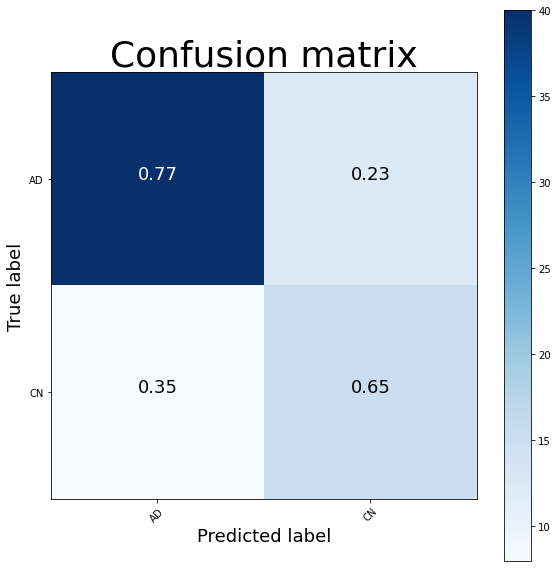

In [38]:
%%time

show_metrics(model, test_seq)

# RISEI

In [39]:
import os
import time
import cv2

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.restoration import inpaint

from multiprocessing import Pool

from tensorflow.keras import preprocessing

from PIL import Image

def generate_mask(params):
    grid = params['grid']
    options = params['options']
    i = params['i']
    image_data = params['image_data']

    shift_x, shift_y, shift_z = __get_random_shift(options)

    # mask has a soft corners
    mask = __get_mask(options, grid, shift_x, shift_y, shift_z)
    # binary mask does not have a soft corners and is used for an inpainting
    binary_mask = __get_binary_mask(options, grid, shift_x, shift_y, shift_z)
    
    inpaint_mask = None
    if options['b1'] > 0:
      inpaint_mask = __get_inpaint_mask(options, image_data, binary_mask)
    
    new_image = __merge(options, image_data, mask, inpaint_mask)

    cache = None
    # when the debug mode is enabled
    # save the generated images to cache
    if options['debug']:
        cache = {
            'grid': grid,
            'binary_mask': binary_mask,
            'inpaint_mask': inpaint_mask,
        }

    return i, new_image, mask, cache

def __merge(options, original_image, mask, inpaint_mask):
    original_image = (original_image - original_image.min())

    # blend original image with inpaint mask if exists
    new_image = original_image

    if inpaint_mask is not None:
      new_image = (1 - options['b1']) * original_image + options['b1'] * inpaint_mask

    # blend original image with inpaint mask with mask
    new_image = new_image * (1 - ((1 - mask) * options['b2']))

    return new_image

def __get_inpaint_mask(options, image_data, binary_mask):
    if options['inpaint'] == '3d':
        return __get_inpaint_mask_3d(options, image_data, binary_mask)
    return __get_inpaint_mask_2d(options, image_data, binary_mask)


def __get_inpaint_mask_3d(options, image_data, binary_mask):
    start = time.time() 

    inverted_binary_mask = 1 - binary_mask.astype(np.uint8)
    inpainted = inpaint.inpaint_biharmonic(image_data, inverted_binary_mask, multichannel=False);
    
    end = time.time()  
    print(f"in: {end - start}")

    return inpained


def __get_inpaint_mask_2d(options, image_data, binary_mask):
    start = time.time() 
    
    inpainted = np.zeros(image_data.shape)
    inverted_binary_mask = (1 - binary_mask).astype(np.uint8)
      
    for z in range(0, image_data.shape[0]):
      inpainted[z] = cv2.inpaint(
          image_data[z],
          inverted_binary_mask[z],
          options['inpaint_radius'],
          options['inpaint_algorithm']
      )

    end = time.time()
    
    # print(f"in: {end - start}")

    return inpainted


def __get_random_shift(options):    
    shift_x = np.random.randint(0, options['over_image_size'][0])
    shift_y = np.random.randint(0, options['over_image_size'][1])
    shift_z = np.random.randint(0, options['over_image_size'][2])

    return shift_x, shift_y, shift_z


def __get_mask(options, grid, shift_x, shift_y, shift_z):
    return resize(grid,
                  options['mask_size'],
                  order=1,
                  mode='reflect',
                  anti_aliasing=False)[shift_y:shift_y + options['input_size'][0], shift_x:shift_x + options['input_size'][1], shift_z:shift_z + options['input_size'][2]]


def __get_binary_mask(options, grid, shift_x, shift_y, shift_z):
    new_grid = np.zeros(options['mask_size'])
    input_size = options['input_size']  
    start = time.time()

    for a in range(0, grid.shape[0]):
      for b in range(0, grid.shape[1]):
        for c in range(0, grid.shape[2]):
          x = a * options['cell_size'][0]
          y = b * options['cell_size'][1]
          z = c * options['cell_size'][2]

          new_grid[x:x + options['cell_size'][0], y:y + options['cell_size'][1], z:z + options['cell_size'][2]] = int(grid[a][b][c])
            
    end = time.time()
    # print(f"gbm: {end - start}")

    return new_grid[shift_x:input_size[0] + shift_x, shift_y:input_size[1] + shift_y, shift_z:input_size[2] + shift_z]


class RISEI():
    def __init__(self, input_size, **kwargs):
        self.options = {
            'input_size': input_size,
            's': kwargs.get('s', 8),  # size of the "grid" - binary mask
            'p1': kwargs.get('p1', 0.5),  # probability of cell being white - transparent
            'b1': kwargs.get('b1', 0.8),  # inpaint mask blend
            'b2': kwargs.get('b2', 0.5),  # black mask blend
            'inpaint': kwargs.get('inpaint', '2d'), # 3d, 2d
            'inpaint_radius': kwargs.get('inpaint_radius', 20),  # inpainting radius
            'inpaint_algorithm': kwargs.get('inpaint_algorithm', cv2.INPAINT_NS), # cv2.INPAINT_TELEA, cv2.INPAINT_NS
            'debug': kwargs.get('debug', False),
            'mask_size': None,
            'cell_size': None,
            'over_image_size': None,
            'processes': kwargs.get('processes', 4),
        }

        self.cache = None

        self.__get_grid_size()

    def generate_masks(self, N, image, log=True):
        self.__initialize_cache(N, image)

        grids = self.__get_empty_grids(N)        
        images_data = self.__get_empty_images_data(N)
        images_mask = self.__get_empty_images_data(N)
        
        params = [{ 'i': i, 'options': self.options, 'grid': grids[i], 'image_data': image } for i in range(0, N)]

        # use process pool only when more than a one process is used
        # in google colab it causes memory leaks
        if self.options['processes'] > 1:
          process_pool = Pool(processes=self.options['processes'])

          with process_pool as p:
              with tqdm(desc='Generating masks', total=N, disable=not log) as pbar:
                  for i, new_image, mask, cache in p.imap_unordered(generate_mask, params):
                      images_data[i, :, :, :] = new_image
                      images_mask[i, :, :, :] = mask

                      if cache is not None:
                          self.__save_to_cache(i, new_image, mask, cache)

                      pbar.update()
          
          process_pool.close()
        else:
          with tqdm(desc='Generating masks', total=N, disable=not log) as pbar:
            for i, new_image, mask, cache in map(generate_mask, params):
                images_data[i, :, :, :] = new_image
                images_mask[i, :, :, :] = mask

                if cache is not None:
                    self.__save_to_cache(i, new_image, mask, cache)

                pbar.update()

        return images_data, images_mask

    def show_from_last_run(self, i, z, figsize=(12, 8), ncols=3, nrows=2):
        original_image = self.show_image_from_last_run(i, z)
        mask = self.show_mask_from_last_run(i, z)
        binary_mask = self.show_binary_mask_from_last_run(i, z)
        inpaint = self.show_inpaint_from_last_run(i, z) if self.options['b1'] > 0 else self.show_image_from_last_run(i, z)
        result = self.show_result_from_last_run(i, z)

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        ax = axes.ravel()

        ax[0].set_title('Original')
        ax[0].imshow(original_image)

        ax[1].set_title('Binary mask')
        ax[1].imshow(binary_mask)

        ax[2].set_title('Mask')
        ax[2].imshow(mask)

        ax[3].set_title('Inpaint')
        ax[3].imshow(inpaint)

        ax[4].set_title('Result')
        ax[4].imshow(result)

        for a in ax:
            a.axis('off')

        fig.tight_layout()
        plt.show()

    def show_mask_from_last_run(self, i, z):
        mask = self.__get_from_cache('masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_binary_mask_from_last_run(self, i, z):
        binary_mask = self.__get_from_cache('binary_masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * binary_mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_image_from_last_run(self, i, z):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')

        return self.cache['image'][z, :, :]

    def show_inpaint_from_last_run(self, i, z):
        return self.__get_from_cache('inpaint_masks', i)[z, :, :]        

    def show_result_from_last_run(self, i, z):
        return self.__get_from_cache('images_data', i)[z, :, :]

    def __get_from_cache(self, key, i):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')
        if len(self.cache[key]) <= i:
            raise Exception(f'Index {i} does not exist!')
        return self.cache[key][i]

    def __save_to_cache(self, i, image_data, mask, cache):
        self.cache['images_data'][i] = image_data
        self.cache['masks'][i] = mask
        self.cache['grids'][i] = cache['grid']        
        self.cache['binary_masks'][i] = cache['binary_mask']
        self.cache['inpaint_masks'][i] = cache['inpaint_mask']

    def __initialize_cache(self, N, image):
        if self.options['debug']:
            self.cache = {
                'image': image,
                'images_data': np.empty((N, *self.options['input_size'])),
                'grids': np.empty((N, self.options['s'], self.options['s'], self.options['s'])),
                'masks': np.empty((N, *self.options['input_size'])),
                'binary_masks': np.empty((N, *self.options['input_size'])),
                'inpaint_masks': np.empty((N, *self.options['input_size'])),
            }
        else:
            self.cache = None
            
    def __get_empty_grids(self, N):
        grids = np.random.rand(N, self.options['s'], self.options['s'], self.options['s']) < self.options['p1']
        return grids.astype('float32')

    def __get_empty_images_data(self, N):
        return np.empty((N, *self.options['input_size']))
    
    def __get_grid_size(self):
        # the size of one pixel (rectangle)
        cell_size = np.ceil(np.array(self.options['input_size']) / self.options['s'])

        # the additional size for each rectangle
        # since we do a crop from the mask, we
        # need to make a "bigger" mask
        # we calculate how much we need to increase the cell
        # to increase the current size by one additional cell
        over_cell_size = np.ceil((((self.options['s'] + 1) * cell_size) - (self.options['s'] * cell_size)) / self.options['s'])

        # new cell size
        new_cell_size = cell_size + over_cell_size

        # mask size (mask is larger than the image)
        mask_size = (self.options['s'] * new_cell_size).astype(np.uint32)

        # difference in size between original image and mask
        over_image_size = mask_size - self.options['input_size']    

        self.options['mask_size'] = mask_size
        self.options['cell_size'] = new_cell_size.astype(np.uint32)
        self.options['over_image_size'] = over_image_size

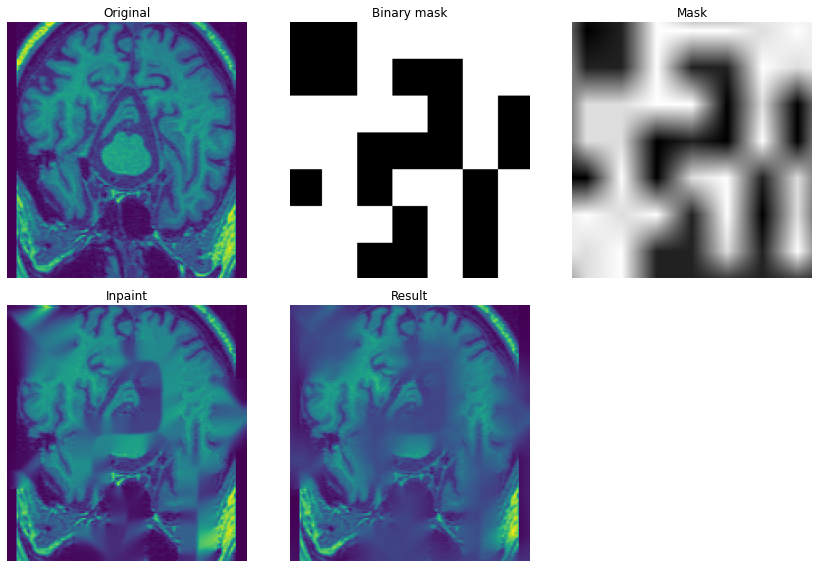

CPU times: user 4.44 s, sys: 260 ms, total: 4.7 s
Wall time: 4.64 s


In [40]:
%%time

raw_image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
image = sitk.GetArrayViewFromImage(raw_image)

risei = RISEI(image.shape, s=8, p1=0.5, b1=0.85, b2=0.9, inpaint="2d", inpaint_radius=5, processes=1, debug=True)

masks = risei.generate_masks(1, image, log=False)

risei.show_from_last_run(0, 60)

# Heatmaps

## Setup

In [41]:
def get_heatmap(x, y, model, risei, batch_size=8, masks_count=24, risei_batch_size=480, debug=False, log=True):
  """
  batch_size - model batch size
  """
  cls_idx = np.argmax(y)

  batch_count = math.ceil(masks_count / risei_batch_size)

  heatmap = np.zeros(shape=x.shape[:3])
  weights = 0

  masks_x = None if debug == False else []
  masks_y = None if debug == False else []

  for batch_idx in range(batch_count):
    if debug == True:
      print(f'\nbatch #{batch_idx} of {batch_count}')

    batch_masks_count = min(risei_batch_size, masks_count - batch_idx * risei_batch_size)
    # Reshape input to risei without channels,
    # then reshape masks back with channels.
    batch_x, masks = risei.generate_masks(batch_masks_count, x.reshape(x.shape[:3]), log=log)
    batch_y = [y for _ in range(batch_masks_count)]
    
    y_pred_per_mask = model.predict(batch_x.reshape((-1, *x.shape)), batch_size=batch_size)

    for mask, mask_x, y_pred in zip(masks, batch_x, y_pred_per_mask):
      # invert the mask, since 1 is for no masking
      # y is the activation for that class on the last layer
      heatmap = heatmap + y_pred[cls_idx] * (1 - mask)
      weights += y_pred[cls_idx]

      if debug == True:
        masks_x.append(mask_x)
        masks_y.append(y_pred[cls_idx])

  if debug == True:
    print(f'\n\ny_true: {cls_idx}')

  heatmap = heatmap / weights

  return heatmap, np.array(masks_x), np.array(masks_y)

In [42]:
from PIL import Image

import cv2
import math


def to_gray_scale(img):
    return (img * 255).astype(np.uint8)


def img_norm(image_x):
  return (image_x - image_x.min()) / (image_x.max() - image_x.min())


def show_heatmap(image_x, heatmap, z=None, alpha=0.5):
  """
  image_x - source image of shape (z, x, y, 1)
  heatmap - a generated heatmap of shape (z, x, y)
  """
  if z is None:
    z = math.ceil(image_x.shape[0] / 2)

  # we need to conver a colormap because 0 is red and 1 is blue
  heatmap_grayscale = to_gray_scale(1 - heatmap[z])
  heatmap_cmap = cv2.applyColorMap(heatmap_grayscale, cv2.COLORMAP_JET)

  image_x_grayscale = to_gray_scale(img_norm(image_x[z].reshape(image_x[z].shape[:2])))
  image_x_cmap = cv2.applyColorMap(image_x_grayscale, cv2.COLORMAP_BONE)

  return Image.blend(Image.fromarray(image_x_cmap, mode='RGB'), Image.fromarray(heatmap_cmap, mode='RGB'), alpha)

In [43]:
def show_mask(index, masks_x, masks_y, z):
  mask = masks_x[index]
  plt.title(f'y_pred:{masks_y[index]}')
  plt.imshow(mask[z].reshape(mask.shape[1:3]))

In [44]:
def plot_heatmap(image_x, image_y, y_pred, heatmap):  
  idx = np.argmax(image_y, axis=0)
  
  plt.subplot(1, 2, 1)
  plt.title(f'y_true: {idx}, y_pred: {y_pred}')
  plt.imshow(image_x.reshape(image_x.shape[:2]))
  plt.colorbar(fraction=0.046, pad=0.04)
  
  plt.subplot(1, 2, 2)
  plt.title(f'y_true: {idx}, y_pred: {y_pred}')
  plt.imshow(image_x.reshape(image_x.shape[:2]))
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  plt.colorbar(fraction=0.046, pad=0.04)
  
  plt.show()

def plot_heatmap_z(image_x, image_y, y_pred, heatmap, z):
  plot_heatmap(image_x[z, :, :], image_y, y_pred, heatmap[z, :, :])

def plot_heatmap_y(image_x, image_y, y_pred, heatmap, y):
  plot_heatmap(image_x[:, y, :], image_y, y_pred, heatmap[:, y, :])

def plot_heatmap_x(image_x, image_y, y_pred, heatmap, x):
  plot_heatmap(image_x[:, :, x], image_y, y_pred, heatmap[:, :, x])

## Generate

In [45]:
image_x = None
image_y = None

batch_x, batch_y = test_seq[0]
print(batch_y)

idx = 3 # 5, 3
image_x = batch_x[idx]
image_y = batch_y[idx]

print(f'y_true: {np.argmax(image_y)}')
y_pred = model.predict(np.array([image_x]))
print(f'y_pred: {np.argmax(y_pred)}')
print(y_pred)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
y_true: 0
y_pred: 0
[[0.91995865 0.08004133]]


In [46]:
# Create a RISEI instance with a config.
# RISEI accepts shape without channels!
#
# p1 = probability of white place to be transparent
# b1 = inpaint mask blend (0 disables inpainting)
# b2 = black mask blend

debug = False

risei = RISEI(image_x.shape[:3], s=8, p1=1/4, b1=0, b2=1, inpaint="2d", inpaint_radius=5, processes=1, debug=debug)

In [47]:
%%time

# get a heatmap for a prediciton
heatmap, masks_x, masks_y = get_heatmap(image_x, image_y, model, risei, batch_size=batch_size, masks_count=120, risei_batch_size=480, debug=debug)

Generating masks: 100%|██████████| 120/120 [00:32<00:00,  3.68it/s]


CPU times: user 5min 48s, sys: 4.22 s, total: 5min 52s
Wall time: 42.4 s


In [48]:
masks_y.shape

()

In [49]:
if debug:
  masks_y

In [50]:
if debug:
  show_mask(0, masks_x, masks_y, 50)

In [51]:
if debug:
  risei.show_from_last_run(0, 56)

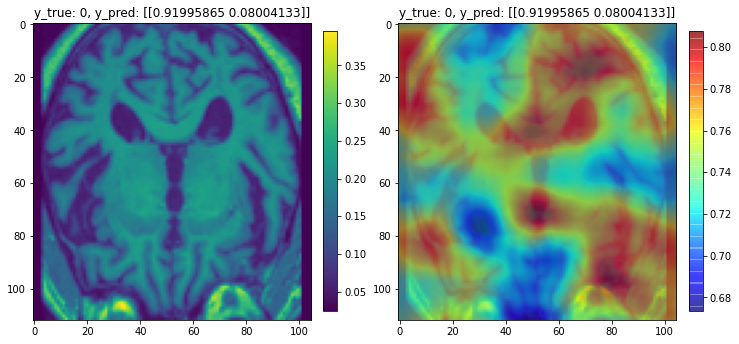

In [52]:
plot_heatmap_z(image_x, image_y, y_pred, heatmap, 56)

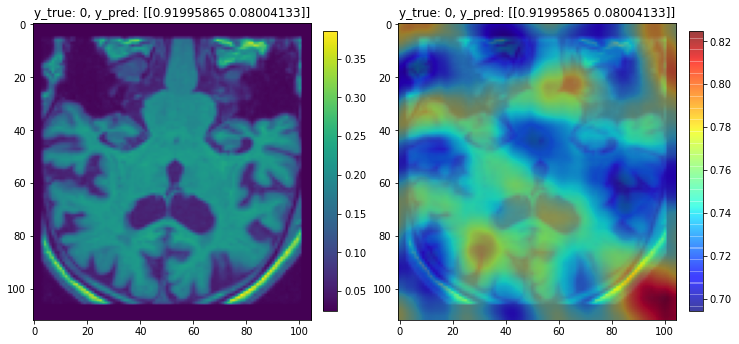

In [53]:
plot_heatmap_y(image_x, image_y, y_pred, heatmap, 56)

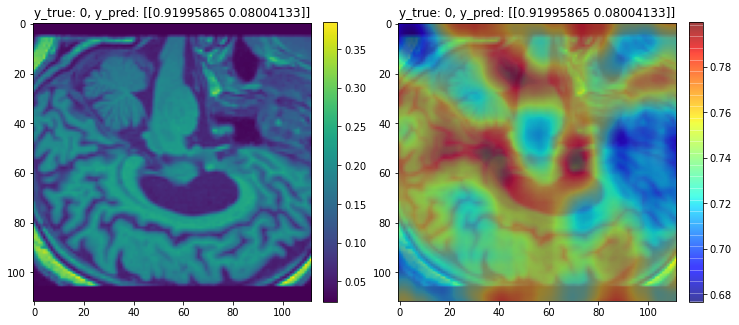

In [54]:
plot_heatmap_x(image_x, image_y, y_pred, heatmap, 56)

# Evaluation

## Setup

In [55]:
def plot_image(image_x):  
  plt.imshow(image_x.reshape(image_x.shape[:2]))


def plot_image_z(image_x, z):
  plot_image(image_x[z, :, :])


def plot_image_y(image_x, y):
  plot_image(image_x[:, y, :])


def plot_image_x(image_x, x):
  plot_image(image_x[:, :, x])

In [56]:
def my_cmp(v):
  return v[0]


# [heat, voxel, (z, y, x)]
def value_to_index(heatmap, image_x, sort='ASC'):
  values = []
  
  for z, _ in enumerate(heatmap):
    for y, _ in enumerate(heatmap[z]):
      for x, _ in enumerate(heatmap[z][y]):
        heat = heatmap[z][y][x]
        voxel = image_x[z][y][x]
        values.append((heat, voxel, (z, y, x)))

  reverse = sort == 'DESC'
  values.sort(reverse=reverse, key=my_cmp)

  return np.array(values)

In [57]:
class EvaluationSequence(Sequence):
    def __init__(self, t, image, heatmap, step_size=1, max_steps=1000, batch_size=8, debug=False, log=True):
      self.t = t
      self.log = log
      self.debug = debug
      self.batch_size = batch_size
      self.image = image
      self.heatmap = heatmap
      
      # cache the images if debug is enabled
      self.cache = []

      # this is insertion
      # [heat, voxel, (z, y, x)]
      self.voxels = value_to_index(heatmap, image, sort='DESC')

      if self.t == 'insertion':
        self.new_image = np.zeros(shape=image.shape)
      else:
        self.new_image = np.copy(image)

      self.step_size = step_size
      self.steps = 0
      self.max_steps = self.__get_max_steps(max_steps)
      self.max_voxels = self.max_steps * step_size

      if self.log == True:  
        print(f'max_steps: {self.max_steps}, batch_size: {self.batch_size}')

      self.tqdm = None
      if self.log == True:
        self.tqdm = tqdm(total=self.__len__())
        
    def __len__(self):
      return math.ceil(self.max_steps / self.batch_size)

    def __getitem__(self, idx):
      batch_x = []
      if self.tqdm is not None:
        self.tqdm.update()
      
      for i in range(self.batch_size):
        step = idx * self.batch_size + i
        # print(f'step: {step}')

        if step >= self.max_steps:
          break;

        start = step * self.step_size
        end = start + self.step_size
        # print(f'{start},{end}')

        # select voxels to add to the image
        s_voxels = self.voxels[start:end]

        for _, voxel, index in s_voxels:
          z, y, x = index

          if self.t == 'insertion':
            # set the value to the voxel (on mutable image)
            self.new_image[z][y][x] = voxel
          else:
            # deletion, remove the voxel
            self.new_image[z][y][x] = 0
        
        # append a copy, because we will mutate the image in next step
        batch_x.append(np.copy(self.new_image))

        if self.debug == True:
          self.cache.append(np.copy(self.new_image))

      batch_x = np.array(batch_x).reshape(-1, *self.new_image.shape)

      return batch_x

    def __get_max_steps(self, max_steps):
      return min(math.ceil(len(self.voxels) / self.step_size), max_steps)

In [58]:
import sklearn


def get_curve(image_y, y_pred, step_size):
  idx = image_y.argmax(axis=0)
  y = y_pred[:, idx]
  x = np.array(list(map(lambda s: s * step_size, range(len(y)))))
  return x, y


def evaluation_auc(image_y, y_pred, step_size):
  x, y = get_curve(image_y, y_pred, step_size)
  return sklearn.metrics.auc(x, y)


def plot_evaluation(image_y, y_pred, eval_seq, title='insertion'):
  idx = image_y.argmax(axis=0)
  x, y = get_curve(image_y, y_pred, eval_seq.step_size)
  auc = evaluation_auc(image_y, y_pred, eval_seq.step_size)
  plt.title(f'{title}: auc={auc}, y_true={idx}, voxel_count:{eval_seq.max_voxels:,} / {len(eval_seq.voxels):,})')
  plt.plot(x, y, linewidth=2)
  ax = plt.gca()
  ax.set_ylabel(f'activation')
  ax.set_xlabel(f'voxels')

In [59]:
def predict_seq_as_np(model, eval_seq, batch_size, log=False):
  """
  predict_seq_as_np
  eval_seq = sequence to evaulate
  batch_size = model.predict() batch size
  """
  y_pred = None
  count = len(eval_seq)

  for i, batch_x in enumerate(eval_seq):
    if log:
      print(f'evaluating batch {i}/{count} of length {len(batch_x)}...')
    batch_y_pred = model.predict(batch_x, batch_size=batch_size)
    if y_pred is None:
      y_pred = batch_y_pred
    else:
      y_pred = np.concatenate([y_pred, batch_y_pred], axis=0)

  return y_pred

## Insertion

In [60]:
%%time

eval_seq_batch_size = batch_size * 4

eval_seq = EvaluationSequence(
    'insertion',
    image_x,
    heatmap,
    step_size=150,
    max_steps=10,
    batch_size=eval_seq_batch_size,
    debug=False,
    log=False
)
y_pred = predict_seq_as_np(model, eval_seq, batch_size, log=True)

evaluating batch 0/1 of length 10...
CPU times: user 32 s, sys: 319 ms, total: 32.3 s
Wall time: 7.88 s


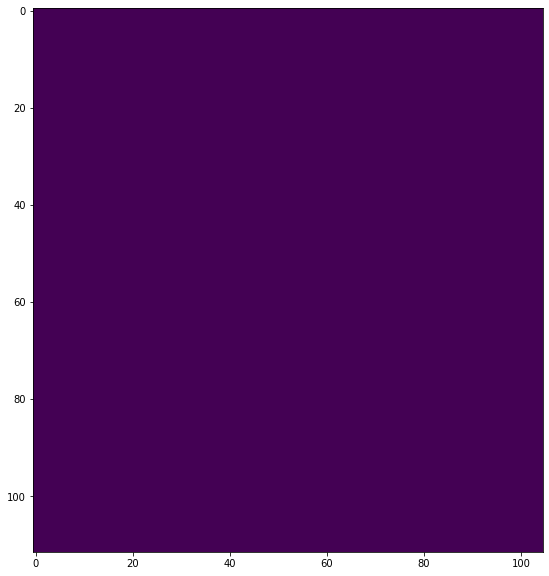

In [61]:
plot_image_z(eval_seq.new_image, 56)

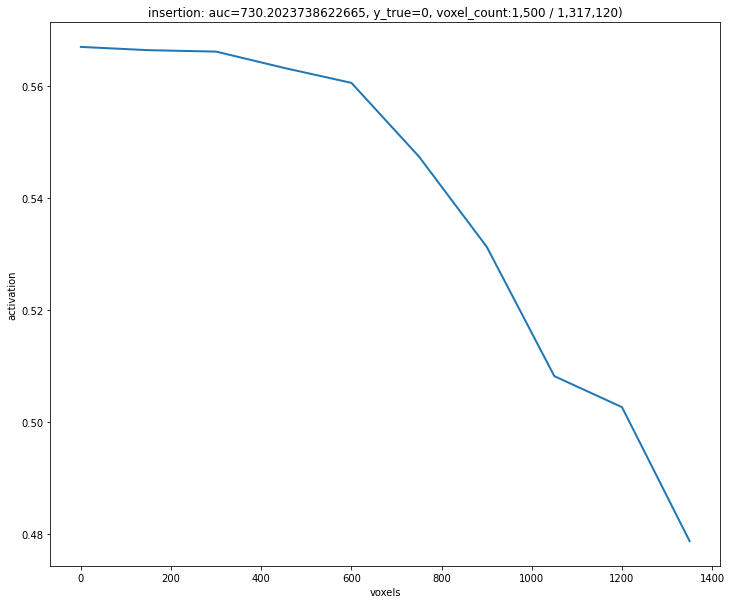

In [62]:
plot_evaluation(image_y, y_pred, eval_seq, title='insertion')

## Deletion

In [63]:
%%time

eval_seq = EvaluationSequence(
    'deletion',
    image_x,
    heatmap,
    step_size=150,
    max_steps=10,
    batch_size=eval_seq_batch_size,
    debug=False,
    log=False
)
y_pred = predict_seq_as_np(model, eval_seq, batch_size, log=False)

CPU times: user 35.3 s, sys: 245 ms, total: 35.5 s
Wall time: 10.1 s


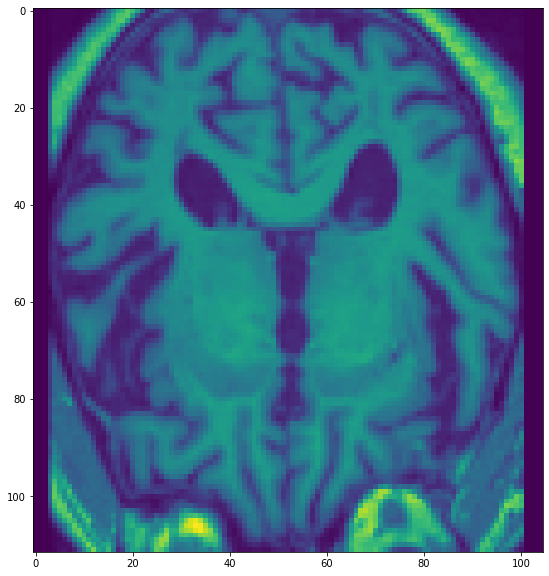

In [64]:
plot_image_z(eval_seq.new_image, 56)

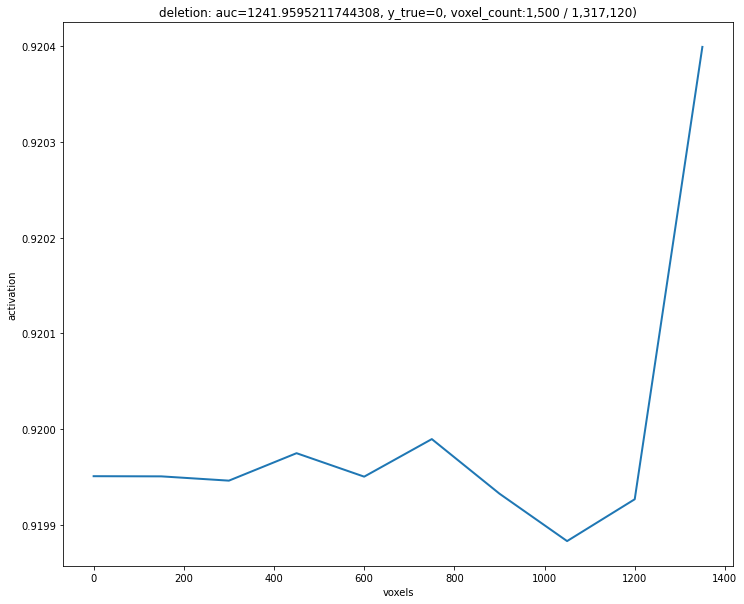

In [65]:
plot_evaluation(image_y, y_pred, eval_seq, title='deletion')

# Batch Evaluation

In [66]:
import time


def evaluate_seq(model,
                 risei,
                 seq,
                 batch_size,
                 masks_count=120,
                 evaluation_step_size=1000,
                 evaluation_max_steps=1000,
                 risei_batch_size=480,
                 evaluation_batch_size=32,
                 method='deletion',
                 log=False,
                 verbose=0):
  evaluations = 0
  length = len(seq.images_dirs)  
  arr_auc = []
  arr_heatmap = []
  arr_x = []
  arr_y = []
  arr_y_pred = []
  arr_y_pred_heatmap = []

  print(f'sequence len: {length}, method: {method}')
  for batch_x, batch_y, *_ in seq:
    batch_y_pred = model.predict(batch_x)

    for i, image in enumerate(zip(batch_x, batch_y)):
      image_x, image_y = image
      y_pred = batch_y_pred[i]
      start = time.time()

      if log:
        print(f'evaluation {evaluations + 1}/{length}')
        print(f'get heatmap (masks: {masks_count})...')

      start_a = time.time()        
      heatmap, _, _ = get_heatmap(
          image_x,
          image_y,
          model,
          risei,
          batch_size=batch_size,
          masks_count=masks_count,
          risei_batch_size=risei_batch_size,
          debug=False,
          log=log and verbose > 1
      )
      end_a = time.time()
      print(f'...finished in {end_a - start_a}s')

      start_a = time.time()
      eval_seq = EvaluationSequence(
          method,
          image_x,
          heatmap,
          step_size=evaluation_step_size,
          max_steps=evaluation_max_steps,
          batch_size=evaluation_batch_size,
          debug=False,
          log=log and verbose > 1
      )
      
      if log:
        print(f'evaluate heatmaps (voxels: {eval_seq.max_steps * eval_seq.step_size}, step_size: {evaluation_step_size}, max_steps: {evaluation_max_steps})...')
      
      y_pred_heatmap = predict_seq_as_np(model, eval_seq, batch_size, log=verbose > 1)
      end_a = time.time()
      if log:
        print(f'...finished in {end_a - start_a}s')
      
      auc = evaluation_auc(image_y, y_pred_heatmap, eval_seq.step_size)
      
      arr_heatmap.append(heatmap)
      arr_x.append(image_x)
      arr_y.append(image_y)
      arr_y_pred_heatmap.append(y_pred_heatmap)
      arr_y_pred.append(y_pred)
      arr_auc.append(auc)
      evaluations += 1
      
      end = time.time()
      
      if log:
        print(f'auc: {auc} ({end - start}s)')
        print()
  
  auc = sum(arr_auc) / evaluations

  return auc, arr_auc, arr_heatmap, arr_x, arr_y, arr_y_pred, arr_y_pred_heatmap

In [67]:
%%time


auc, arr_auc, arr_heatmap, arr_x, arr_y, arr_y_pred, arr_y_pred_heatmap = evaluate_seq(
    model,
    risei,
    val_seq,
    batch_size=batch_size,
    masks_count=720,
    evaluation_step_size=150,
    evaluation_max_steps=10000,
    risei_batch_size=240,
    evaluation_batch_size=batch_size * 12,
    log=True,
    verbose=1,
    method='insertion',
  )

print(f'auc: {auc}')

sequence len: 25, method: insertion
evaluation 1/25
get heatmap (masks: 720)...
...finished in 257.3736424446106s
evaluate heatmaps (voxels: 1317150, step_size: 150, max_steps: 10000)...
...finished in 739.1350202560425s
auc: 132609.60959596268 (996.5139355659485s)

evaluation 2/25
get heatmap (masks: 720)...
...finished in 250.44316506385803s
evaluate heatmaps (voxels: 1317150, step_size: 150, max_steps: 10000)...
...finished in 736.9773685932159s
auc: 906480.9559303103 (987.4252905845642s)

evaluation 3/25
get heatmap (masks: 720)...
...finished in 249.47402501106262s
evaluate heatmaps (voxels: 1317150, step_size: 150, max_steps: 10000)...
...finished in 760.5021064281464s
auc: 896419.338350615 (1009.9802858829498s)

evaluation 4/25
get heatmap (masks: 720)...
...finished in 250.3992247581482s
evaluate heatmaps (voxels: 1317150, step_size: 150, max_steps: 10000)...
...finished in 758.4288620948792s
auc: 715561.9090732536 (1008.8321614265442s)

evaluation 5/25
get heatmap (masks: 720)

In [73]:
def batch_evaluation_heatmap(idx, fn, arr_heatmap, arr_x, arr_y, arr_y_pred, arr_y_pred_heatmap):
  if arr_y_pred_heatmap is not None:
    print(f'y_pred_heatmap: {np.average(arr_y_pred[idx], axis=0)}')
  return fn(arr_x[idx], arr_y[idx], arr_y_pred[idx], arr_heatmap[idx], 56)

y_pred_heatmap: 0.5


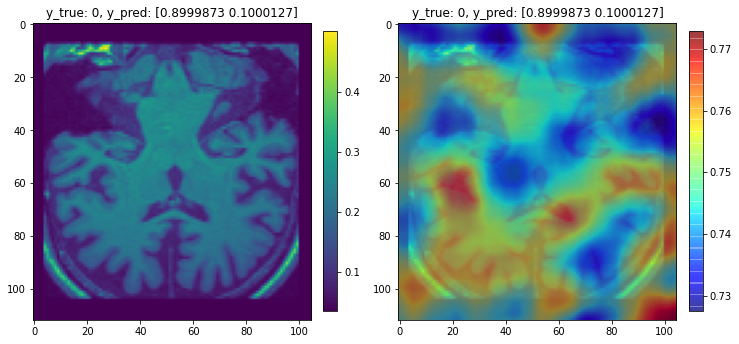

In [74]:
batch_evaluation_heatmap(0, plot_heatmap_y, arr_heatmap, arr_x, arr_y, arr_y_pred, arr_y_pred_heatmap)

y_pred_heatmap: 0.5


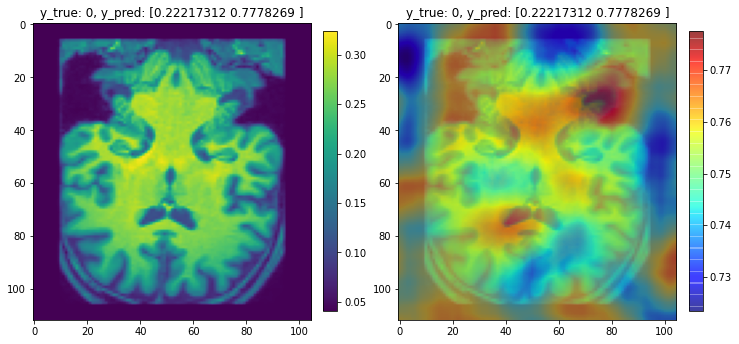

In [75]:
batch_evaluation_heatmap(2, plot_heatmap_y, arr_heatmap, arr_x, arr_y, arr_y_pred, arr_y_pred_heatmap)

In [71]:
arr_auc

[132609.60959596268,
 906480.9559303103,
 896419.338350615,
 715561.9090732536,
 207765.26848903298,
 48659.08875341766,
 240520.90827495063,
 1938.7143072433919,
 243968.65640554475,
 247588.26160694959,
 29600.35548865043,
 136639.85970813056,
 209985.98853137845,
 522805.2385032177,
 1001081.565447757,
 354289.0023043098,
 101500.32492560649,
 256409.75919461343,
 246996.0999068755,
 685146.3084397536,
 413966.3236503176,
 1007669.1021897714,
 888731.5894242855,
 61179.44267873821,
 365389.22155435465]